In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (Dense,
                                     BatchNormalization,
                                     LeakyReLU,
                                     Reshape,
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)
import matplotlib.pyplot as plt

In [ ]:
#underscore to omit the label arrays
(train_images, train_labels), (_,_)=tf.keras.datasets.mnist.load_data()

train_images=train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
train_images=(train_images-127.5)/127.5 #Normalize to [-1,1]

BUFFER_SIZE= 60000
BATCH_SIZE= 256

#Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
def generator_model():
  model = tf.keras.Sequential()
  model.add(Dense(7*7*256, use_bias=False,input_shape=(100,)))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Reshape((7,7,256)))
  assert model.output_shape==(None,7,7,256) # None is batch size
#a transposed convolution layer with 128 filters and 5x5 kernel size
#This layer increases the spatial dimension
  model.add(Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))
  assert model.output_shape==(None,7,7,128)
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))
#This effectively doubles spacial dimension from 7x7 to 14x14
  assert model.output_shape==(None,14,14,64)
  model.add(BatchNormalization())
  model.add(LeakyReLU())
#Goal is toproduce an output image with a single channel, which corresponds to a grayscale image so 1 filter is used
  model.add(Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias=False,activation='tanh'))
  assert model.output_shape==(None,28,28,1)

  print(model.summary())
  return model

In [ ]:
generator= generator_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12544)               │       1,254,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12544)               │          50,176 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 7, 7, 128)           │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 14, 14, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │           1,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

None


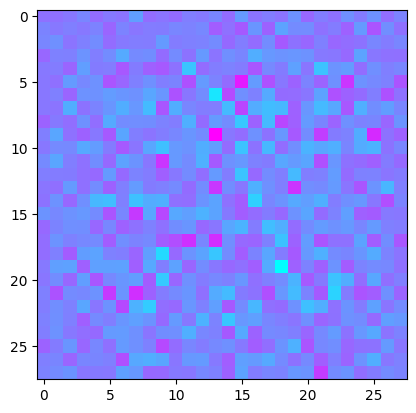

In [ ]:
#Create random noise and generate a sample
noise = tf.random.normal([1,100]) #random tensor with a shape of [1,100]
generated_image = generator(noise, training=False) #Passess the noise vector through the generator model
#Visualize the generated model
plt.imshow(generated_image[0,:,:,0],cmap='cool')

In [ ]:
def discriminator_model():
  model= tf.keras.Sequential()
  model.add(Conv2D(64,(5,5),strides= (2,2),padding='same',input_shape=[28,28,1]))
  model.add(LeakyReLU())
  model.add(Dropout(0.3))

  model.add(Conv2D(128,(5,5),strides=(2,2),padding='same'))
  model.add(LeakyReLU())
  model.add(Dropout(0.3))

  model.add(Flatten())
  model.add(Dense(1))

  print(model.summary())
  return model

In [ ]:
discriminator= discriminator_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
#This method returns a helper function to compute cross entropy loss
cross_entropy= tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output,fake_output):
  real_loss= cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss= cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss= real_loss+fake_loss
  return total_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)

generator_optimizer= tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer= tf.keras.optimizers.Adam(1e-4)

In [ ]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_opimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS= 60
#we'll reuse this seed overtime to visualize progress in animated GIF
num_examples_to_generate= 16
noise_dim=100
seed= tf.random.normal([num_examples_to_generate,noise_dim])

In [ ]:
@tf.function
def train_step(images):
  noise= tf.random.normal([BATCH_SIZE,noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images= generator(noise,training=True)

    real_output= discriminator(images,training=True)
    fake_output= discriminator(generated_images,training=True)

    gen_loss= generator_loss(fake_output)
    disc_loss= discriminator_loss(real_output,fake_output)

  gradients_of_generator= gen_tape.gradient(gen_loss,generator.trainable_variables)
  gradients_of_discriminator= disc_tape.gradient(disc_loss,discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))

  return gen_loss,disc_loss

In [ ]:
def generate_and_save_images(gen_model, epoch, test_input):
  #Notice training is set to False
  #This is so all layers run in inference mode(batchnorm)
  #1- generate images
  predictions= gen_model(test_input,training=False)
  #2.plot generated image
  fig= plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i,:,:,0]*127.5+127.5,cmap='gray')
    plt.axis('off')
  #save image
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
# for epoch in range(EPOCHS):
#   avg_gen_loss=0
#   avg_disc_loss=0
#   num_batches=0

#   for image_batch in train_dataset:
#     gen_loss,disc_loss= train_step(image_batch)

#     avg_gen_loss+=gen_loss
#     avg_disc_loss+=disc_loss

In [ ]:
import time
from IPython import display
def train(dataset,epochs):
  for epoch in range(epochs):
    start= time.time()
    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epoch+1,
                           seed)
    if(epoch+1)%15==0:
      checkpoint.save(file_prefix=checkpoint_prefix)

      print('Time for epoch {} is {} sec'.format(epoch+1,time.time()-start))

      display.clear_output(wait=True)
      generate_and_save_images(generator,
                               epochs,
                               seed)

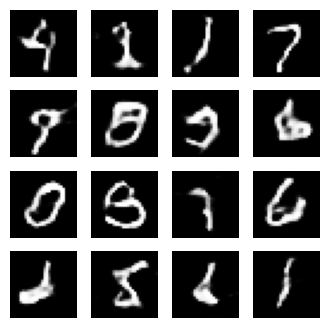

In [ ]:
train(train_dataset,EPOCHS)

<ipython-input-34-4e97cd7ec71c>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


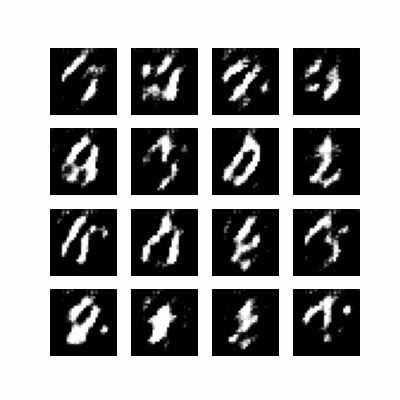

In [ ]:
import glob
import imageio

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)

display.Image(open('dcgan.gif','rb').read())